In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt


tensor([[-0.7942,  2.1050],
        [-9.1516, -4.8129],
        [-3.1037,  3.9020],
        [-1.4295,  5.1685],
        [-7.4694, -4.2020]], dtype=torch.float64) <class 'torch.Tensor'>
tensor([0, 1, 0, 0, 1], dtype=torch.int32) <class 'torch.Tensor'>


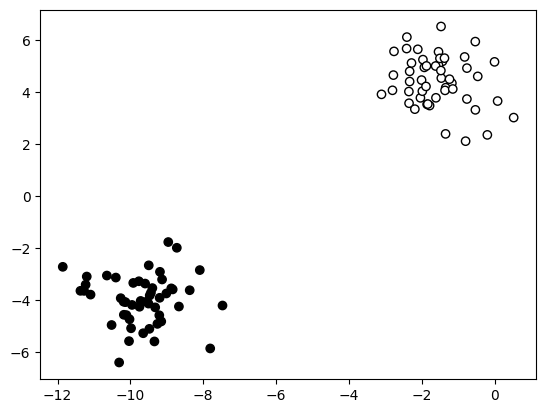

In [2]:
import sklearn.datasets as skds
X, Y = skds.make_blobs(n_samples=100, n_features=2,
                       centers=2, random_state=1)
X, Y = torch.tensor(X), torch.tensor(Y)
print(X[:5,:],type(X))
print(Y[:5],type(Y))
plt.scatter(X[:, 0], X[:, 1],
            c=Y, cmap="Greys", edgecolor="black");


In [3]:
def draw_prob_contours():
  x0, x1 = torch.linspace(-12, 1, 100), torch.linspace(-7, 7, 100)
  grid0, grid1 = torch.meshgrid(x0, x1)
  fig = plt.contour(grid0, grid1, model(w0, w1, b, grid0, grid1), cmap="Greys")
  fig.clabel(inline=True, fontsize=10)
  plt.scatter(X[:, 0], X[:, 1],
            c=Y, cmap="Greys", edgecolor="black");

z         = lambda w0,w1,b,x0,x1: w0*x0 + w1*x1 + b
y         = lambda z: 1 / (1+torch.exp(-z))
clip_prob = lambda y: torch.max(eps, torch.min(1-eps,y)) 
model     = lambda w0,w1,b,x0,x1: clip_prob(y(z(w0, w1, b, x0, x1)))
eps       = torch.tensor(10**-6)
H         = lambda y,yt: -(yt*torch.log(y) + (1-yt)*torch.log(1-y))
C         = lambda cost_per_point: cost_per_point.mean()
cost_by_w0w1 = lambda w0,w1: C(H(model(w0, w1, b, X[:, 0], X[:, 1]), Y))

tensor(0.8867, dtype=torch.float64)


C:\Users\ernms\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


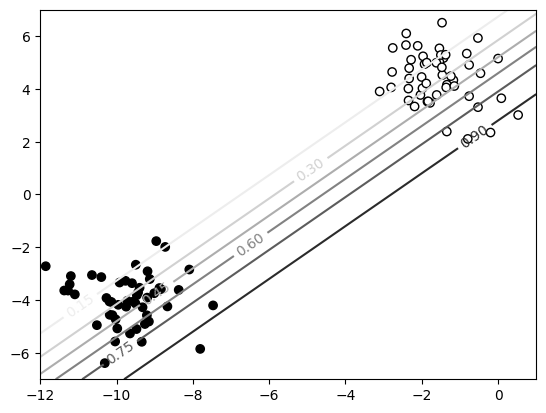

In [4]:
b=5
w0, w1 = 1, -1
draw_prob_contours()
cost = cost_by_w0w1(w0, w1)
print(cost)

tensor(4.9074, dtype=torch.float64)


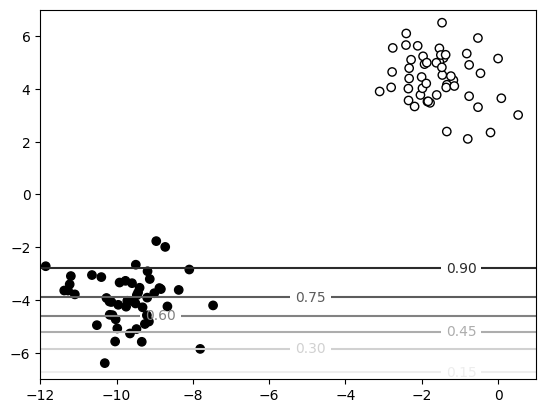

In [5]:

w0, w1 = 0, 1
draw_prob_contours()
cost = cost_by_w0w1(w0, w1)
print(cost)

In [6]:
b=5
range0, range1 = torch.linspace(-1, 2, 100), torch.linspace(-2,2, 100)
grid0, grid1   = torch.meshgrid(range0, range1)
grid_cost      = torch.zeros(grid0.size())
#this code is slow - vecotrize it.
for index0 in range(len(range0)):
  for index1 in range(len(range1)):
    w0 = grid0[index0,index1]
    w1 = grid1[index0,index1]
    grid_cost[index0,index1] = C(H(model(w0, w1, b, X[:, 0], X[:, 1]), Y))

In [8]:
def GD(alpha):
  w = torch.tensor([1.4, 1.4], requires_grad=True)
  iterations   = 10
  history      = torch.zeros(1+iterations, 2)
  history[0,:] = w.detach()
  for idx in range(iterations):
    cost = cost_by_w0w1(w[0], w[1])
    cost.backward()
    with torch.no_grad():
      w -= alpha*w.grad
    w.grad.zero_()
    history[1+idx,:] = w.detach()
  return history

In [9]:
def SGD(alpha):
  w = torch.tensor([1.4, 1.4], requires_grad=True)
  iterations   = 10
  history      = torch.zeros(1+iterations,2)
  history[0,:] = w.detach()
  batch_idx    = 1
  batch_size   = 2
  for idx in range(iterations):
    X_batch   = X[batch_idx:(batch_idx+batch_size),:]
    Y_batch   = Y[batch_idx:(batch_idx+batch_size)]
    batch_idx = batch_idx+batch_size

    cost=C(H(model(
        w[0], w[1], b, X_batch[:, 0], X_batch[:, 1]), Y_batch))
    cost.backward()
    with torch.no_grad():
      w -= alpha*w.grad
    w.grad.zero_()
    history[1+idx,:] = w.detach()
  return history

In [10]:
def eggholder(w0,w1):
  a = -(w1+47) * torch.sin(torch.sqrt(torch.abs(w1 + w0/2 + 47)))
  b = -w0 * torch.sin(torch.sqrt(torch.abs(w0 - (w1 + 47))))
  return a+b

In [11]:
range0, range1 = torch.linspace(0, 512, 1000), torch.linspace(0, 512, 1000)
grid0, grid1   = torch.meshgrid(range0, range1)
grid_cost      = torch.zeros(grid0.size())
grid_cost      = eggholder(grid0, grid1)

In [12]:
def GD_egg(alpha=1, start=[250., 350.]):
  w            = torch.tensor(start, requires_grad=True)
  iterations   = 10
  history      = torch.zeros(1+iterations,2)
  history[0,:] = w.detach()
  for idx in range(iterations):
    cost = eggholder(w[0], w[1])
    cost.backward()
    with torch.no_grad():
      w -= alpha*w.grad
    w.grad.zero_()
    history[1+idx,:] = w.detach()
  return history

In [14]:

def draw_descent():
  plt.contourf(grid0, grid1, grid_cost, cmap="Greys");
  plt.scatter(history[0,0], history[0,1], marker="o", color="r")
  plt.scatter(history[-1,0], history[-1,1], marker="x", s=100, color="r")
  plt.plot(history[:,0], history[:,1], linestyle=':', marker="x", color="r")
  plt.xlabel("w0");
  plt.ylabel("w1");

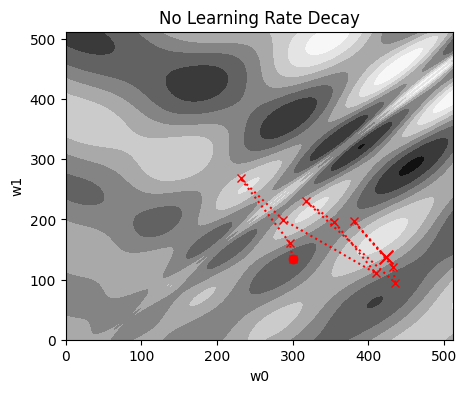

In [15]:
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
history = GD_egg(5, start=[300.,135.])
draw_descent()
plt.title("No Learning Rate Decay");

In [18]:
history

tensor([[300.0000, 135.0000],
        [296.0009, 161.3980],
        [231.2237, 268.0238],
        [287.2355, 199.5534],
        [409.4453, 110.7234],
        [355.1163, 195.7208],
        [317.1722, 230.4679],
        [435.6841,  94.3321],
        [432.2639, 121.1194],
        [380.6235, 197.0595],
        [422.6456, 137.7906]])

In [ ]:
torch.optim.lr_scheduler

C:\Users\ernms\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


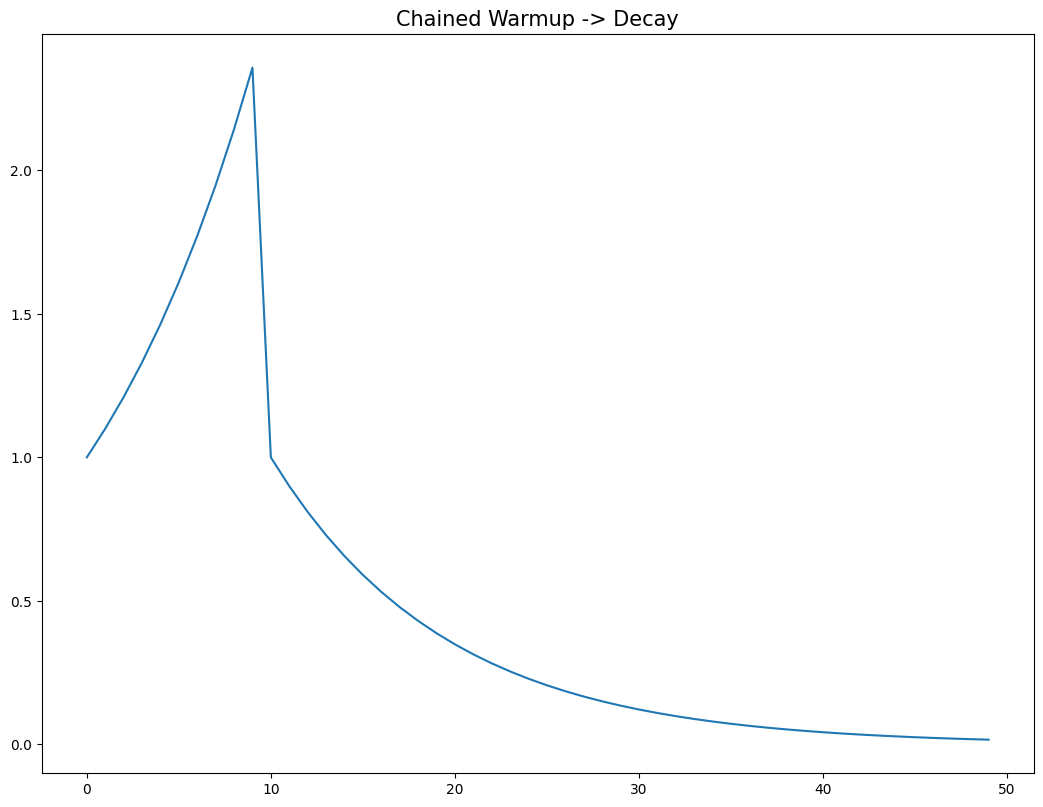

In [19]:
start=[250.,350.]
w         = torch.tensor(start,requires_grad=True)
model     = [w]
optimizer = torch.optim.SGD(model, lr=1)
warmup = lambda epoch: 1.1 ** epoch 
decay  = lambda epoch: 0.9 ** epoch
scheduler1 = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup)
scheduler2 = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=decay)
scheduler  = torch.optim.lr_scheduler.SequentialLR(optimizer,
            schedulers=[scheduler1, scheduler2], milestones=[10])

num_epochs = 50
num_minibatches = 1
alphas =torch.zeros(num_epochs)

for epoch in range(num_epochs):
    for batch in range(num_minibatches):
      optimizer.step()
    alphas[epoch] = optimizer.param_groups[0]["lr"]
    scheduler.step()

plt.figure(figsize=[12.8, 9.6])
plt.plot(range(num_epochs), alphas);
plt.title("Chained Warmup -> Decay", size=15);